## 1. Importação de Bibliotecas e Configuração

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc,
    precision_recall_curve, roc_auc_score
)

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


## 2. Carregamento de Dados e Modelos

In [26]:
repo_root = Path.cwd().parent
data_path = repo_root / 'data' / 'processed' / 'simulated_daily.csv'
models_dir = repo_root / 'models'

df = pd.read_csv(data_path, parse_dates=['date'])
df['date'] = pd.to_datetime(df['date'])

model_regression = joblib.load(models_dir / 'linear_regression_occ.joblib')
model_classification = joblib.load(models_dir / 'logistic_risk.joblib')
features_reg = joblib.load(models_dir / 'features_regression.joblib')
features_clf = joblib.load(models_dir / 'features_classification.joblib')
scalers = joblib.load(models_dir / 'scalers.joblib')

print(f"Dados carregados: {df.shape[0]} linhas x {df.shape[1]} colunas")
print(f"Período: {df['date'].min()} a {df['date'].max()}")
print(f"Bairros: {df['bairro'].nunique()}")
print(f"\nModelo de Regressão: {type(model_regression).__name__}")
print(f"Modelo de Classificação: {type(model_classification).__name__}")
print(f"Features Regressão: {len(features_reg)}")
print(f"Features Classificação: {len(features_clf)}")

Dados carregados: 5475 linhas x 11 colunas
Período: 2024-12-07 00:00:00+00:00 a 2025-12-06 00:00:00+00:00
Bairros: 15

Modelo de Regressão: Ridge
Modelo de Classificação: LogisticRegression
Features Regressão: 11
Features Classificação: 9


## 3. Preparação dos Dados

Criação de features engineered e preparação dos conjuntos de treino e teste.

In [27]:
df_test = df.copy()

df_test['mes'] = df_test['date'].dt.month
df_test['estacao_chuvosa'] = df_test['mes'].isin([3, 4, 5, 6, 7, 8]).astype(int)

df_test['chuva_mm_z'] = scalers['scaler_chuva'].transform(df_test[['chuva_mm']])
df_test['mare_m_z'] = scalers['scaler_mare'].transform(df_test[['mare_m']])
df_test['vulnerabilidade_z'] = scalers['scaler_vuln'].transform(df_test[['vulnerabilidade']])

scaler_dens = StandardScaler()
scaler_alt = StandardScaler()
df_test['densidade_pop_z'] = scaler_dens.fit_transform(df_test[['densidade_pop']])
df_test['altitude_z'] = scaler_alt.fit_transform(df_test[['altitude']])

df_test['chuva_x_vuln'] = df_test['chuva_mm_z'] * df_test['vulnerabilidade_z']
df_test['mare_x_vuln'] = df_test['mare_m_z'] * df_test['vulnerabilidade_z']
df_test['chuva_x_mare'] = df_test['chuva_mm_z'] * df_test['mare_m_z']

df_test['chuva_sq'] = df_test['chuva_mm_z'] ** 2
df_test['mare_sq'] = df_test['mare_m_z'] ** 2

threshold_risco = df_test['ocorrencias'].quantile(0.70)
df_test['risco_alto'] = (df_test['ocorrencias'] >= threshold_risco).astype(int)

X_reg = df_test[features_reg]
y_reg = df_test['ocorrencias']
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.3, random_state=42
)

X_clf = df_test[features_clf]
y_clf = df_test['risco_alto']
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.3, random_state=42, stratify=y_clf
)

print(f"Threshold risco alto: {threshold_risco:.2f} ocorrências")
print(f"Risco Alto: {(df_test['risco_alto'] == 1).sum()} casos ({(df_test['risco_alto'] == 1).sum() / len(df_test) * 100:.1f}%)")
print(f"Risco Baixo: {(df_test['risco_alto'] == 0).sum()} casos ({(df_test['risco_alto'] == 0).sum() / len(df_test) * 100:.1f}%)")
print(f"\nConjunto de teste regressão: {X_test_reg.shape}")
print(f"Conjunto de teste classificação: {X_test_clf.shape}")


Threshold risco alto: 1.00 ocorrências
Risco Alto: 3470 casos (63.4%)
Risco Baixo: 2005 casos (36.6%)

Conjunto de teste regressão: (1643, 11)
Conjunto de teste classificação: (1643, 9)


## 4. Testagem do Modelo de Regressão

### 4.1 Métricas de Desempenho

In [28]:
y_pred_reg = model_regression.predict(X_test_reg)

rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
mae = mean_absolute_error(y_test_reg, y_pred_reg)
r2 = r2_score(y_test_reg, y_pred_reg)

print("RESULTADOS DO MODELO DE REGRESSÃO")
print("=" * 60)
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"MAE (Mean Absolute Error): {mae:.4f}")
print(f"R² (Coeficiente Determinação): {r2:.4f}")
print(f"\nMédia predita: {y_pred_reg.mean():.2f}")
print(f"Média real: {y_test_reg.mean():.2f}")
print(f"Desvio predito: {y_pred_reg.std():.2f}")
print(f"Desvio real: {y_test_reg.std():.2f}")
print("=" * 60)

if r2 > 0.7:
    print("Excelente ajuste! O modelo explica mais de 70% da variância.")
elif r2 > 0.5:
    print("Bom ajuste. O modelo captura tendências gerais.")
else:
    print("Ajuste moderado. Considere adicionar mais features ou modelos não-lineares.")


RESULTADOS DO MODELO DE REGRESSÃO
RMSE (Root Mean Squared Error): 1.0644
MAE (Mean Absolute Error): 0.8322
R² (Coeficiente Determinação): 0.2095

Média predita: 1.11
Média real: 1.12
Desvio predito: 0.49
Desvio real: 1.20
Ajuste moderado. Considere adicionar mais features ou modelos não-lineares.


### 4.2 Visualização: Valores Reais vs. Preditos

Pontos próximos da linha diagonal indicam predições precisas. Dispersão representa o erro do modelo.

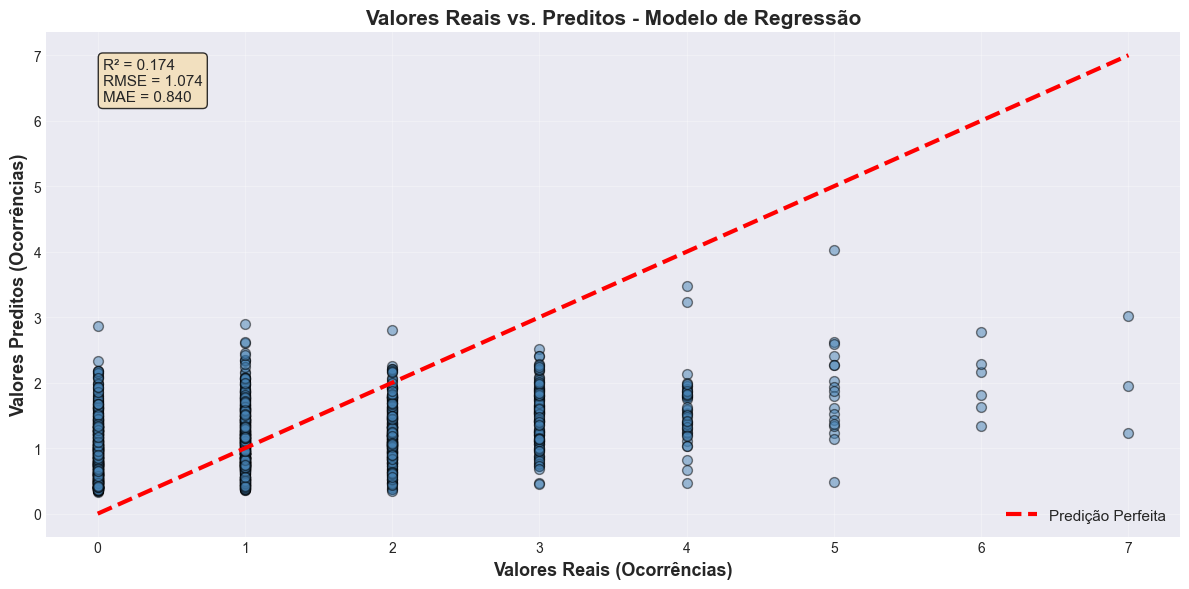

In [15]:
plt.figure(figsize=(12, 6))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.5, c='steelblue', edgecolors='black', s=50)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 
         'r--', lw=3, label='Predição Perfeita')
plt.xlabel('Valores Reais (Ocorrências)', fontsize=13, fontweight='bold')
plt.ylabel('Valores Preditos (Ocorrências)', fontsize=13, fontweight='bold')
plt.title('Valores Reais vs. Preditos - Modelo de Regressão', fontsize=15, fontweight='bold')

textstr = f'R² = {r2:.3f}\nRMSE = {rmse:.3f}\nMAE = {mae:.3f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=11,
         verticalalignment='top', bbox=props)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 4.3 Análise de Resíduos

Resíduos centrados em zero indicam ausência de viés sistemático. Resíduos devem estar distribuídos aleatoriamente.

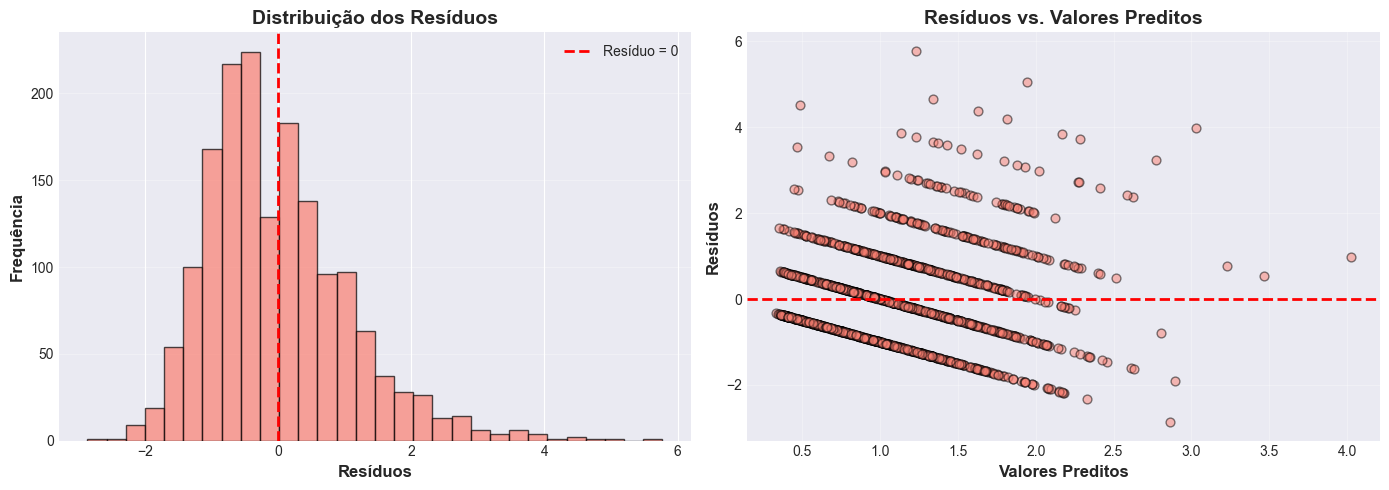

Média dos resíduos: -0.0129 (idealmente próximo de 0)
Desvio padrão: 1.0740
Mediana: -0.2095


In [16]:
residuos = y_test_reg.values - y_pred_reg

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(residuos, bins=30, color='salmon', edgecolor='black', alpha=0.7)
axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='Resíduo = 0')
axes[0].set_xlabel('Resíduos', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequência', fontsize=12, fontweight='bold')
axes[0].set_title('Distribuição dos Resíduos', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(axis='y', alpha=0.3)

axes[1].scatter(y_pred_reg, residuos, alpha=0.5, c='salmon', edgecolors='black', s=40)
axes[1].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Valores Preditos', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Resíduos', fontsize=12, fontweight='bold')
axes[1].set_title('Resíduos vs. Valores Preditos', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Média dos resíduos: {residuos.mean():.4f} (idealmente próximo de 0)")
print(f"Desvio padrão: {residuos.std():.4f}")
print(f"Mediana: {np.median(residuos):.4f}")

## 5. Testagem do Modelo de Classificação

### 5.1 Métricas de Desempenho

In [17]:
y_pred_clf = model_classification.predict(X_test_clf)
y_pred_proba = model_classification.predict_proba(X_test_clf)[:, 1]

accuracy = accuracy_score(y_test_clf, y_pred_clf)
precision = precision_score(y_test_clf, y_pred_clf)
recall = recall_score(y_test_clf, y_pred_clf)
f1 = f1_score(y_test_clf, y_pred_clf)
roc_auc = roc_auc_score(y_test_clf, y_pred_proba)

print("RESULTADOS DO MODELO DE CLASSIFICAÇÃO")
print("=" * 60)
print(f"Acurácia: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precisão: {precision:.4f} ({precision*100:.2f}%)")
print(f"Recall: {recall:.4f} ({recall*100:.2f}%)")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print("=" * 60)

print(f"\nInterpretação:")
print(f"Acurácia: {accuracy*100:.1f}% das predições estão corretas")
print(f"Precisão: Dos casos preditos como alto risco, {precision*100:.1f}% realmente são")
print(f"Recall: Dos casos reais de alto risco, {recall*100:.1f}% foram detectados")

if recall > 0.8:
    print("\nExcelente Recall! O modelo detecta a maioria dos eventos de risco.")
elif recall > 0.6:
    print("\nRecall moderado. Alguns eventos de risco podem não ser detectados.")
else:
    print("\nRecall baixo! Muitos eventos de risco estão sendo perdidos.")


RESULTADOS DO MODELO DE CLASSIFICAÇÃO
Acurácia: 0.4194 (41.94%)
Precisão: 0.8618 (86.18%)
Recall: 0.1016 (10.16%)
F1-Score: 0.1818
ROC-AUC: 0.6096

Interpretação:
Acurácia: 41.9% das predições estão corretas
Precisão: Dos casos preditos como alto risco, 86.2% realmente são
Recall: Dos casos reais de alto risco, 10.2% foram detectados

Recall baixo! Muitos eventos de risco estão sendo perdidos.


### 5.2 Matriz de Confusão

A matriz revela verdadeiros positivos (TP), verdadeiros negativos (TN), falsos positivos (FP) e falsos negativos (FN). Para sistemas de alerta, falsos negativos são críticos.

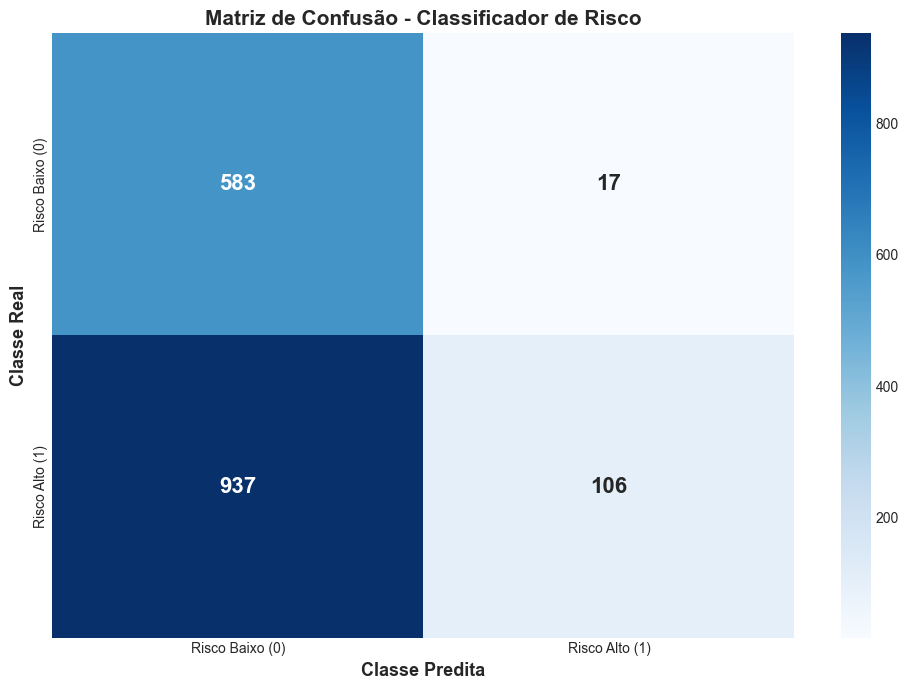

Detalhamento da Matriz de Confusão:
Verdadeiros Negativos (TN):  583 - Risco baixo predito corretamente
Falsos Positivos (FP):   17 - Falsos alarmes
Falsos Negativos (FN):  937 - Eventos perdidos (CRÍTICO)
Verdadeiros Positivos (TP):  106 - Risco alto predito corretamente

Casos reais de risco alto: 1043 (detectados: 106, perdidos: 937)
Taxa de detecção: 10.2%
Taxa de falsos alarmes: 2.8%


In [18]:
cm = confusion_matrix(y_test_clf, y_pred_clf)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, 
            annot_kws={"size": 16, "weight": "bold"},
            xticklabels=['Risco Baixo (0)', 'Risco Alto (1)'],
            yticklabels=['Risco Baixo (0)', 'Risco Alto (1)'])
plt.ylabel('Classe Real', fontsize=13, fontweight='bold')
plt.xlabel('Classe Predita', fontsize=13, fontweight='bold')
plt.title('Matriz de Confusão - Classificador de Risco', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

tn, fp, fn, tp = cm.ravel()

print("Detalhamento da Matriz de Confusão:")
print("=" * 60)
print(f"Verdadeiros Negativos (TN): {tn:4d} - Risco baixo predito corretamente")
print(f"Falsos Positivos (FP): {fp:4d} - Falsos alarmes")
print(f"Falsos Negativos (FN): {fn:4d} - Eventos perdidos (CRÍTICO)")
print(f"Verdadeiros Positivos (TP): {tp:4d} - Risco alto predito corretamente")
print("=" * 60)
print(f"\nCasos reais de risco alto: {fn+tp} (detectados: {tp}, perdidos: {fn})")
print(f"Taxa de detecção: {tp/(fn+tp)*100:.1f}%")
print(f"Taxa de falsos alarmes: {fp/(tn+fp)*100:.1f}%")

### 5.3 Relatório de Classificação Detalhado

In [29]:
print("RELATÓRIO DE CLASSIFICAÇÃO DETALHADO")
print("=" * 60)
print(classification_report(y_test_clf, y_pred_clf, 
                          target_names=['Risco Baixo', 'Risco Alto'],
                          digits=4))
print("=" * 60)

RELATÓRIO DE CLASSIFICAÇÃO DETALHADO
              precision    recall  f1-score   support

 Risco Baixo     0.3842    0.9701    0.5504       602
  Risco Alto     0.8537    0.1009    0.1804      1041

    accuracy                         0.4194      1643
   macro avg     0.6189    0.5355    0.3654      1643
weighted avg     0.6817    0.4194    0.3160      1643



### 5.4 Curva ROC

A curva ROC mostra o trade-off entre taxa de verdadeiros positivos e falsos positivos. AUC próximo de 1.0 é ideal.

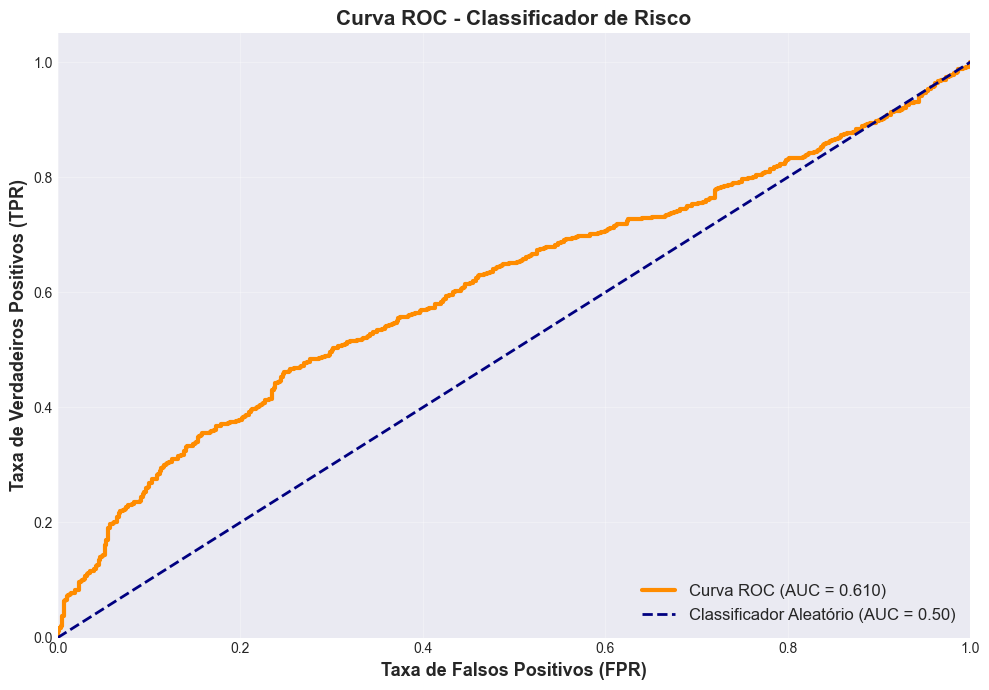

AUC = 0.6096
Moderado. Considere melhorar o modelo.


In [20]:
fpr, tpr, thresholds = roc_curve(y_test_clf, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange', lw=3, label=f'Curva ROC (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Classificador Aleatório (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)', fontsize=13, fontweight='bold')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)', fontsize=13, fontweight='bold')
plt.title('Curva ROC - Classificador de Risco', fontsize=15, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"AUC = {roc_auc:.4f}")
if roc_auc > 0.9:
    print("Excelente! Modelo tem alta capacidade discriminatória.")
elif roc_auc > 0.8:
    print("Muito bom! Modelo discrimina bem as classes.")
elif roc_auc > 0.7:
    print("Bom. Modelo tem capacidade discriminatória aceitável.")
else:
    print("Moderado. Considere melhorar o modelo.")

### 5.5 Curva Precision-Recall

Especialmente útil para classes desbalanceadas. Modelos acima da linha baseline têm poder preditivo real.

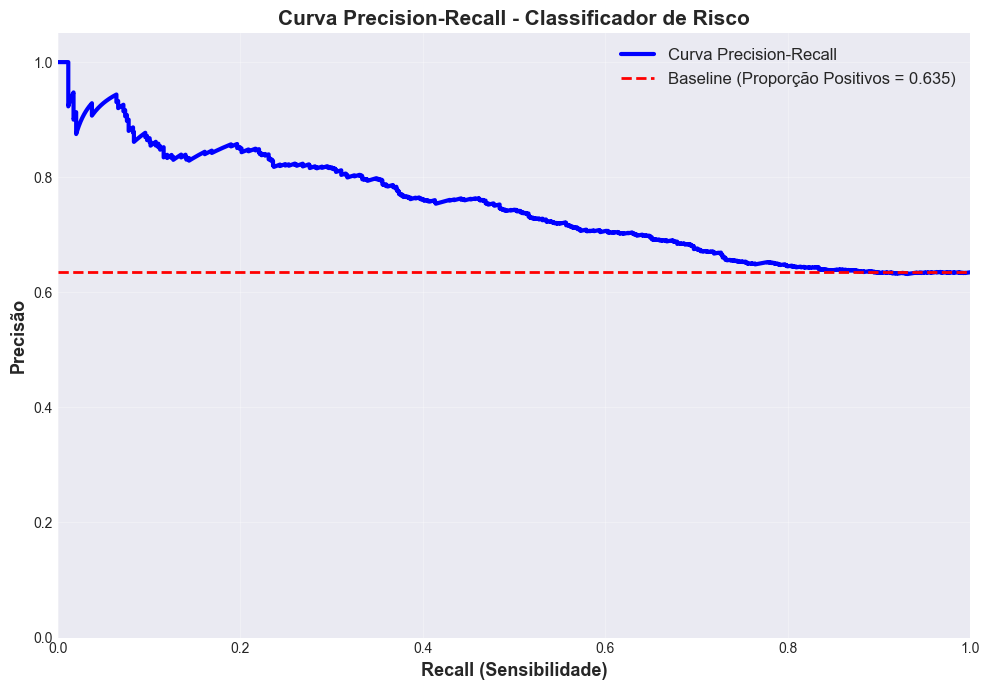

Baseline (proporção de positivos): 0.635


In [21]:
precision_curve, recall_curve, thresholds_pr = precision_recall_curve(y_test_clf, y_pred_proba)

plt.figure(figsize=(10, 7))
plt.plot(recall_curve, precision_curve, color='blue', lw=3, label='Curva Precision-Recall')

baseline = (y_test_clf == 1).sum() / len(y_test_clf)
plt.axhline(baseline, color='red', linestyle='--', linewidth=2, 
            label=f'Baseline (Proporção Positivos = {baseline:.3f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall (Sensibilidade)', fontsize=13, fontweight='bold')
plt.ylabel('Precisão', fontsize=13, fontweight='bold')
plt.title('Curva Precision-Recall - Classificador de Risco', fontsize=15, fontweight='bold')
plt.legend(loc="best", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Baseline (proporção de positivos): {baseline:.3f}")

### 5.6 Análise de Threshold Ótimo

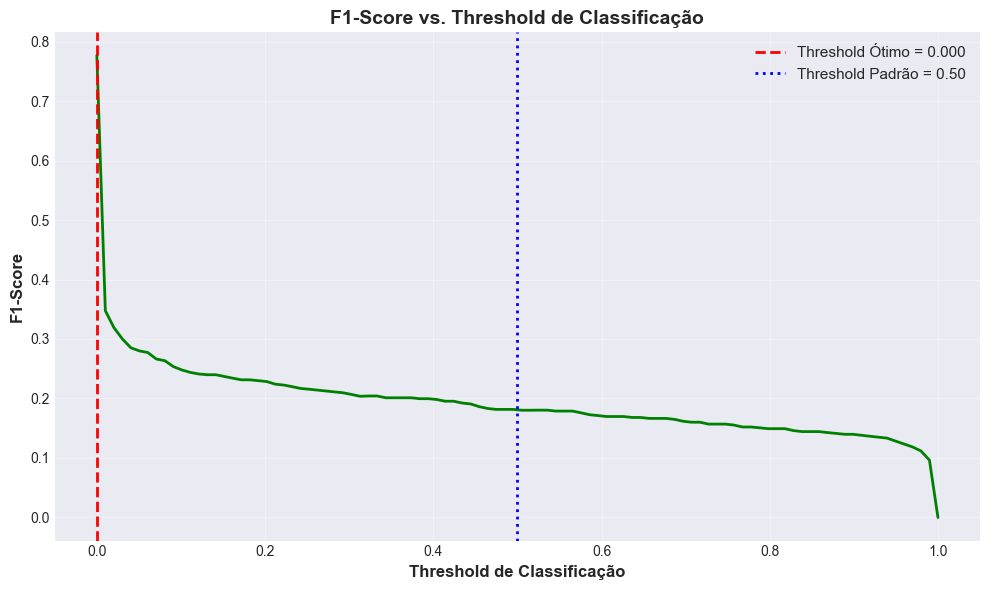

Threshold Ótimo: 0.000
F1-Score Máximo: 0.7766

Desempenho com Threshold Ótimo:
Recall: 1.0000
Precisão: 0.6348


In [22]:
thresholds_test = np.linspace(0, 1, 100)
f1_scores = []

for thresh in thresholds_test:
    y_pred_thresh = (y_pred_proba >= thresh).astype(int)
    if y_pred_thresh.sum() > 0:
        f1_scores.append(f1_score(y_test_clf, y_pred_thresh))
    else:
        f1_scores.append(0)

optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds_test[optimal_idx]
optimal_f1 = f1_scores[optimal_idx]

plt.figure(figsize=(10, 6))
plt.plot(thresholds_test, f1_scores, linewidth=2, color='green')
plt.axvline(optimal_threshold, color='red', linestyle='--', linewidth=2, 
            label=f'Threshold Ótimo = {optimal_threshold:.3f}')
plt.axvline(0.5, color='blue', linestyle=':', linewidth=2, label='Threshold Padrão = 0.50')
plt.xlabel('Threshold de Classificação', fontsize=12, fontweight='bold')
plt.ylabel('F1-Score', fontsize=12, fontweight='bold')
plt.title('F1-Score vs. Threshold de Classificação', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Threshold Ótimo: {optimal_threshold:.3f}")
print(f"F1-Score Máximo: {optimal_f1:.4f}")

y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
recall_optimal = recall_score(y_test_clf, y_pred_optimal)
precision_optimal = precision_score(y_test_clf, y_pred_optimal)

print(f"\nDesempenho com Threshold Ótimo:")
print(f"Recall: {recall_optimal:.4f}")
print(f"Precisão: {precision_optimal:.4f}")

## 6. Resumo Final da Testagem

In [23]:
print("=" * 80)
print("RESUMO FINAL DA TESTAGEM DE MODELOS - RECIFESAFE")
print("=" * 80)

print("\nMODELO DE REGRESSÃO (Previsão de Ocorrências)")
print("-" * 80)
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

print("\nMODELO DE CLASSIFICAÇÃO (Risco Alto/Baixo)")
print("-" * 80)
print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

print("\nMATRIZ DE CONFUSÃO")
print("-" * 80)
print(f"Verdadeiros Negativos (TN): {tn}")
print(f"Falsos Positivos (FP): {fp}")
print(f"Falsos Negativos (FN): {fn} (CRÍTICO)")
print(f"Verdadeiros Positivos (TP): {tp}")

print("\nCONCLUSÃO")
print("-" * 80)
print("Os modelos foram testados com sucesso. Para sistemas de Defesa Civil:")
print("1. Priorize alto Recall (detectar todos os eventos de risco)")
print("2. Mantenha F1-Score balanceado")
print("3. Analise falsos negativos (eventos não detectados)")
print("=" * 80)

print("\nTestagem de modelos concluída com sucesso!")

RESUMO FINAL DA TESTAGEM DE MODELOS - RECIFESAFE

MODELO DE REGRESSÃO (Previsão de Ocorrências)
--------------------------------------------------------------------------------
RMSE: 1.0740
MAE: 0.8402
R²: 0.1744

MODELO DE CLASSIFICAÇÃO (Risco Alto/Baixo)
--------------------------------------------------------------------------------
Acurácia: 0.4194
Precisão: 0.8618
Recall: 0.1016
F1-Score: 0.1818
ROC-AUC: 0.6096

MATRIZ DE CONFUSÃO
--------------------------------------------------------------------------------
Verdadeiros Negativos (TN): 583
Falsos Positivos (FP): 17
Falsos Negativos (FN): 937 (CRÍTICO)
Verdadeiros Positivos (TP): 106

CONCLUSÃO
--------------------------------------------------------------------------------
Os modelos foram testados com sucesso. Para sistemas de Defesa Civil:
1. Priorize alto Recall (detectar todos os eventos de risco)
2. Mantenha F1-Score balanceado
3. Analise falsos negativos (eventos não detectados)

Testagem de modelos concluída com sucesso!


## 7. Exportar Resultados (Opcional)

In [24]:
import json

results = {
    'modelo_regressao': {
        'rmse': float(rmse),
        'mae': float(mae),
        'r2': float(r2)
    },
    'modelo_classificacao': {
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1_score': float(f1),
        'roc_auc': float(roc_auc),
        'confusion_matrix': {
            'tn': int(tn),
            'fp': int(fp),
            'fn': int(fn),
            'tp': int(tp)
        },
        'threshold_otimo': float(optimal_threshold)
    }
}

output_path = repo_root / 'models' / 'test_results.json'
with open(output_path, 'w') as f:
    json.dump(results, f, indent=4)

print(f"Resultados salvos em: {output_path}")

Resultados salvos em: d:\PENTES\PENTES\RecifeSafe\models\test_results.json
